This uses a different environment, because grpcio -> ray -> neuralforecast only works via conda on Mac M1 🙄

In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
import sys

sys.path.append("/Users/david/Repositories/protest-impact")

## Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

In [2]:
# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds <= "1959-12-31"]  # 132 train
Y_test_df = Y_df[Y_df.ds > "1959-12-31"]  # 12 test

In [3]:
Y_df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [4]:
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_epochs=50),
]
#   NHITS(input_size=2 * horizon, h=horizon, max_epochs=50)]
nf = NeuralForecast(models=models, freq="M")
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

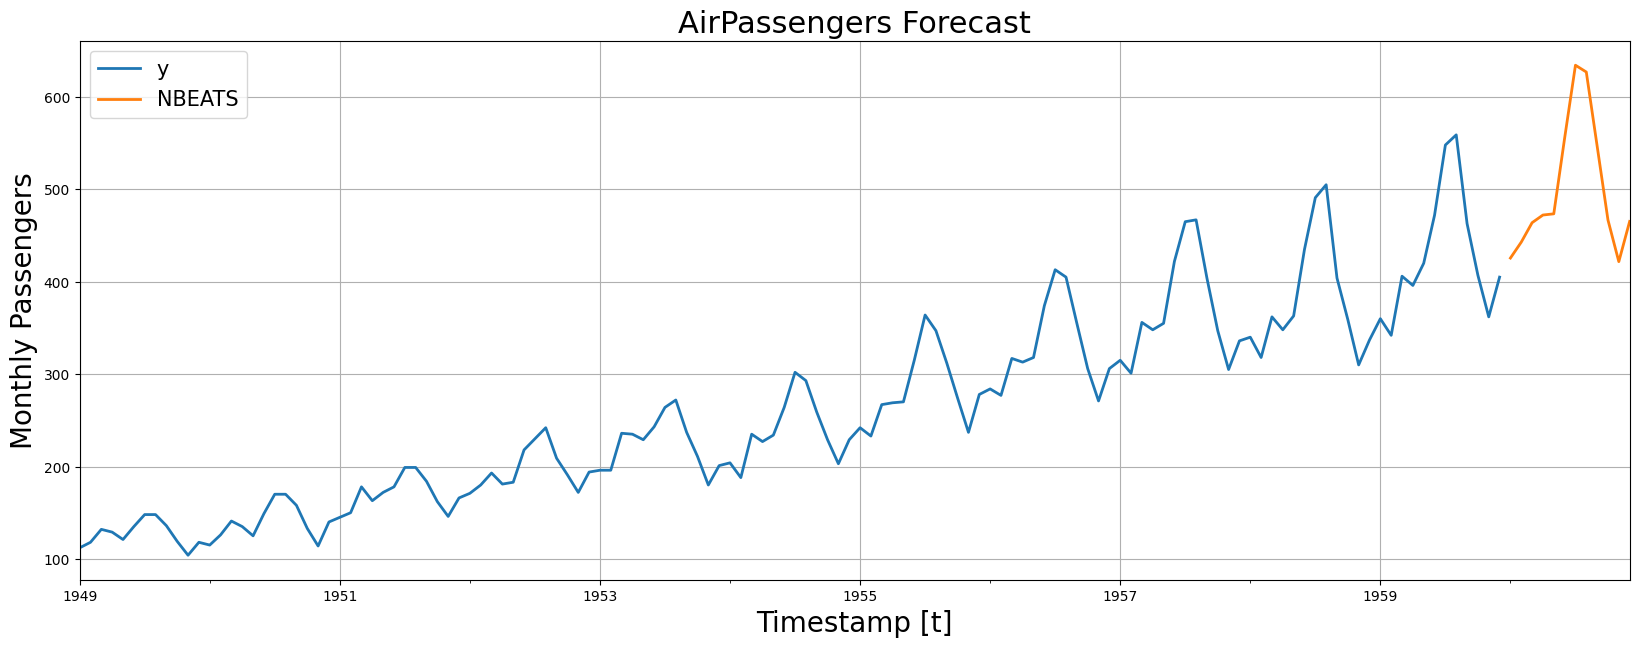

In [6]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how="left", on=["unique_id", "ds"])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index("ds")

# plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)
plot_df[["y", "NBEATS"]].plot(ax=ax, linewidth=2)

ax.set_title("AirPassengers Forecast", fontsize=22)
ax.set_ylabel("Monthly Passengers", fontsize=20)
ax.set_xlabel("Timestamp [t]", fontsize=20)
ax.legend(prop={"size": 15})
ax.grid()

## Application

In [34]:
from protest_impact.synthetic_region import get_standard_time_series

ts = get_standard_time_series("random", 20)

In [35]:
X, Y, p = ts[1]
X.head()

,Bayern_(klima OR,Berlin_(klima OR,Brandenburg_(klima OR,Bremen_(klima OR,Hamburg_(klima OR,Hessen_(klima OR,Niedersachsen_(klima OR,Rheinland-Pfalz_(klima OR,Saarland_(klima OR,Sachsen_(klima OR,Sachsen-Anhalt_(klima OR,Schleswig-Holstein_(klima OR,Thüringen_(klima OR
-168,26,8,3,1,3,28,25,5,2,3,0,7,0
-167,25,8,3,0,7,26,25,4,2,7,1,3,2
-166,48,14,5,2,9,47,33,7,2,10,2,8,0
-165,32,20,5,1,12,41,51,10,2,10,1,10,0
-164,46,19,5,1,3,16,26,1,2,10,0,8,1


In [36]:
import pandas as pd

df = pd.concat([Y, X], axis=1)
df = df.rename(columns={Y.name: "y"})
df["unique_id"] = [1] * len(df)
df["ds"] = df.index
df.head()

,y,Bayern_(klima OR,Berlin_(klima OR,Brandenburg_(klima OR,Bremen_(klima OR,Hamburg_(klima OR,Hessen_(klima OR,Niedersachsen_(klima OR,Rheinland-Pfalz_(klima OR,Saarland_(klima OR,Sachsen_(klima OR,Sachsen-Anhalt_(klima OR,Schleswig-Holstein_(klima OR,Thüringen_(klima OR,unique_id,ds
-168,22,26,8,3,1,3,28,25,5,2,3,0,7,0,1,-168
-167,21,25,8,3,0,7,26,25,4,2,7,1,3,2,1,-167
-166,35,48,14,5,2,9,47,33,7,2,10,2,8,0,1,-166
-165,33,32,20,5,1,12,41,51,10,2,10,1,10,0,1,-165
-164,27,46,19,5,1,3,16,26,1,2,10,0,8,1,1,-164


In [37]:
df_train = df[df.index < 0]
df_test = df[df.index >= 0]

In [38]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS

In [39]:
models = [
    NHITS(
        h=28,
        input_size=168 - 28,
        futr_exog_list=X.columns,  # <- Future exogenous variables
        scaler_type="robust",
        max_epochs=50,
    ),
    NBEATS(
        h=28,
        input_size=168 - 28,
        futr_exog_list=X.columns,  # <- Future exogenous variables
        scaler_type="robust",
        max_epochs=50,
    ),
]

lightning_fabric.utilities.seed INFO  Global seed set to 1
lightning_fabric.utilities.seed INFO  Global seed set to 1


In [40]:
nf = NeuralForecast(models=models, freq="W")
nf.fit(df=df_train)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [41]:
Y_hat_df = nf.predict(futr_df=df_test)
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,ds,NHITS,NBEATS
unique_id,,,
1,0,31.364069,32.122517
1,1,47.659210,41.259537
1,2,68.146957,57.638283
1,3,70.916748,71.240723
1,4,59.097870,61.827785


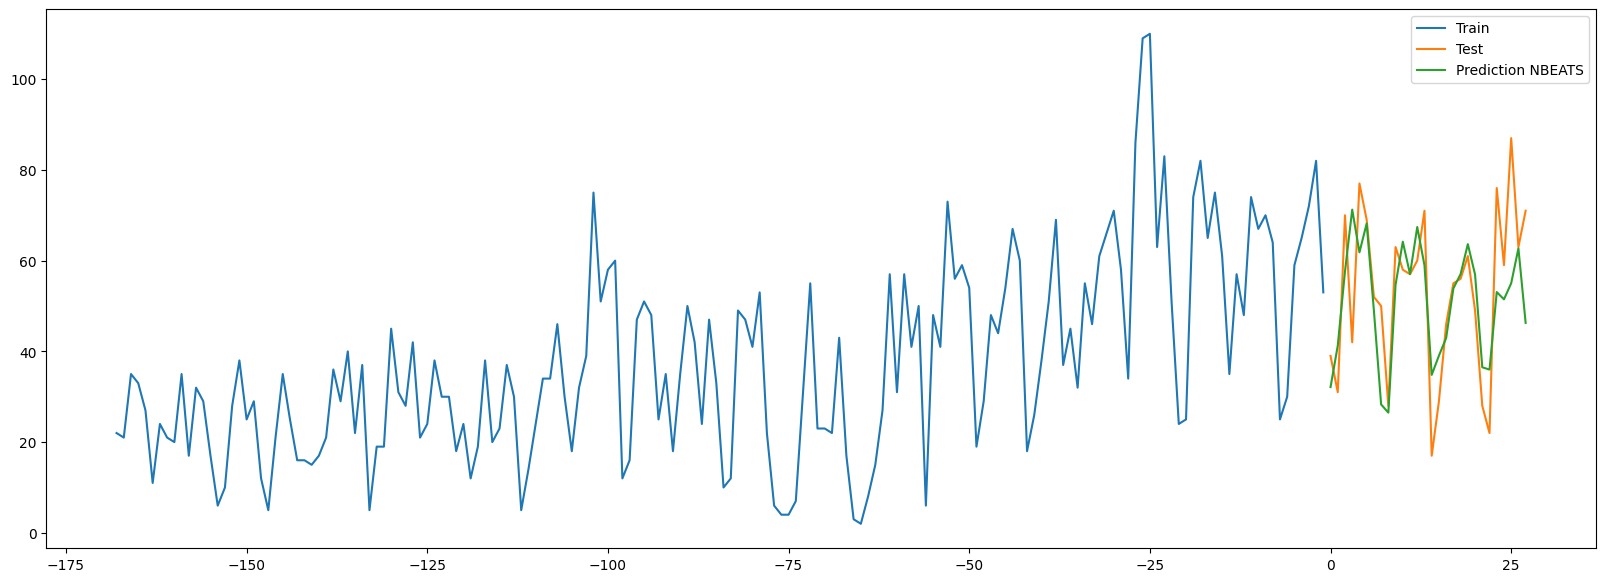

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 7))
ax.plot(df_train.index, df_train.y, label="Train")
ax.plot(df_test.index, df_test.y, label="Test")
# ax.plot(df_test.index, Y_hat_df.NHITS, label='Prediction NHITS')
ax.plot(df_test.index, Y_hat_df.NBEATS, label="Prediction NBEATS")
ax.legend()

Neat.

For comparison, ridge regression:

In [44]:
from protest_impact.synthetic_region import models, synthetic_region

results = synthetic_region(X, Y, p, models["ridge"])

In [48]:
df_ = results["df"]
pred_ridge = df_[df_.index >= p["event_date"]]["synth"]

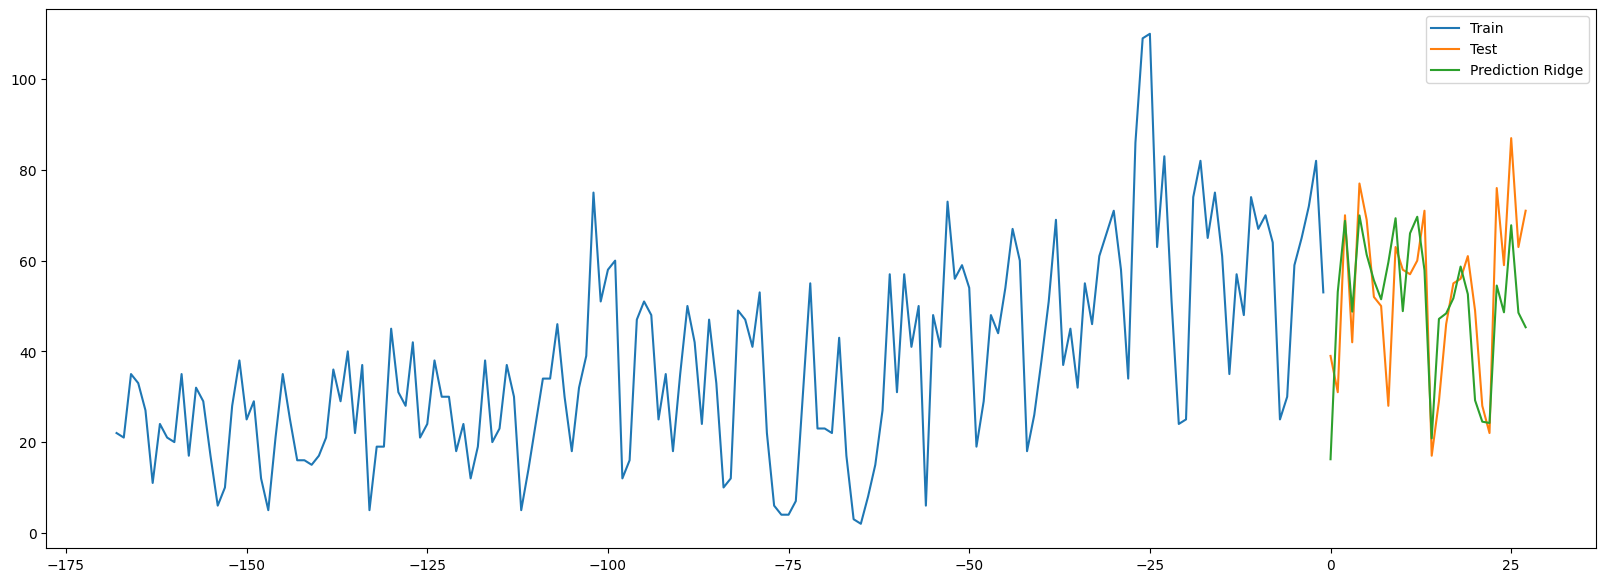

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
ax.plot(df_train.index, df_train.y, label="Train")
ax.plot(df_test.index, df_test.y, label="Test")
ax.plot(df_test.index, pred_ridge, label="Prediction Ridge")
ax.legend()

Each one seems better for a certain aspect of the prediction.

## Evaluating on many time series

In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoLSTM, AutoNBEATS, AutoNHITS
from neuralforecast.losses.pytorch import RMSE
from ray import tune

In [4]:
from protest_impact.synthetic_region import get_standard_time_series

ts = get_standard_time_series("random", 20)

In [5]:
import pandas as pd

dfs = []
for i, t in enumerate(ts):
    X, Y, p = t
    df = pd.concat([Y, X], axis=1)
    df["ds"] = pd.Timestamp(p["event_date"]) + pd.to_timedelta(df.index, unit="D")
    df["unique_id"] = [f"ts{i}"] * len(df)
    # reorder columns and put unique_id and ds first
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]
    df = df.rename(columns={Y.name: "y"})
    dfs.append(df)
    print(i, p["admin1"])
Y_df = pd.concat(dfs)

0 Nordrhein-Westfalen
1 Nordrhein-Westfalen
2 Rheinland-Pfalz
3 Nordrhein-Westfalen
4 Hamburg
5 Schleswig-Holstein
6 Niedersachsen
7 Niedersachsen
8 Niedersachsen
9 Bayern
10 Nordrhein-Westfalen
11 Schleswig-Holstein
12 Rheinland-Pfalz
13 Niedersachsen
14 Niedersachsen
15 Nordrhein-Westfalen
16 Nordrhein-Westfalen
17 Niedersachsen
18 Niedersachsen
19 Niedersachsen


In [6]:
Y_df

,ds,unique_id,y,Bayern_(klima OR,Berlin_(klima OR,Brandenburg_(klima OR,Bremen_(klima OR,Hamburg_(klima OR,Hessen_(klima OR,Niedersachsen_(klima OR,Rheinland-Pfalz_(klima OR,Saarland_(klima OR,Sachsen_(klima OR,Schleswig-Holstein_(klima OR,Thüringen_(klima OR,Sachsen-Anhalt_(klima OR,Nordrhein-Westfalen_(klima OR
-168,2021-08-30,ts0,109,81.0,31,7,0.0,16.0,44.0,63.0,13.0,6,10.0,14.0,3,NaN,NaN
-167,2021-08-31,ts0,83,63.0,24,1,0.0,19.0,93.0,90.0,15.0,2,27.0,18.0,0,NaN,NaN
-166,2021-09-01,ts0,128,93.0,31,10,0.0,22.0,157.0,114.0,22.0,9,21.0,13.0,0,NaN,NaN
-165,2021-09-02,ts0,168,174.0,36,16,0.0,35.0,197.0,172.0,34.0,14,47.0,37.0,0,NaN,NaN
-164,2021-09-03,ts0,163,143.0,40,9,0.0,30.0,100.0,174.0,18.0,11,48.0,42.0,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,2020-12-24,ts19,57,39.0,8,3,0.0,5.0,16.0,NaN,2.0,2,8.0,3.0,0,0.0,27.0
24,2020-12-25,ts19,18,11.0,3,0,0.0,3.0,13.0,NaN,1.0,1,6.0,2.0,0,0.0,18.0
25,2020-12-26,ts19,16,20.0,6,2,2.0,5.0,9.0,NaN,1.0,1,5.0,2.0,0,1.0,9.0
26,2020-12-27,ts19,15,11.0,9,3,4.0,5.0,69.0,NaN,5.0,3,5.0,4.0,3,0.0,32.0


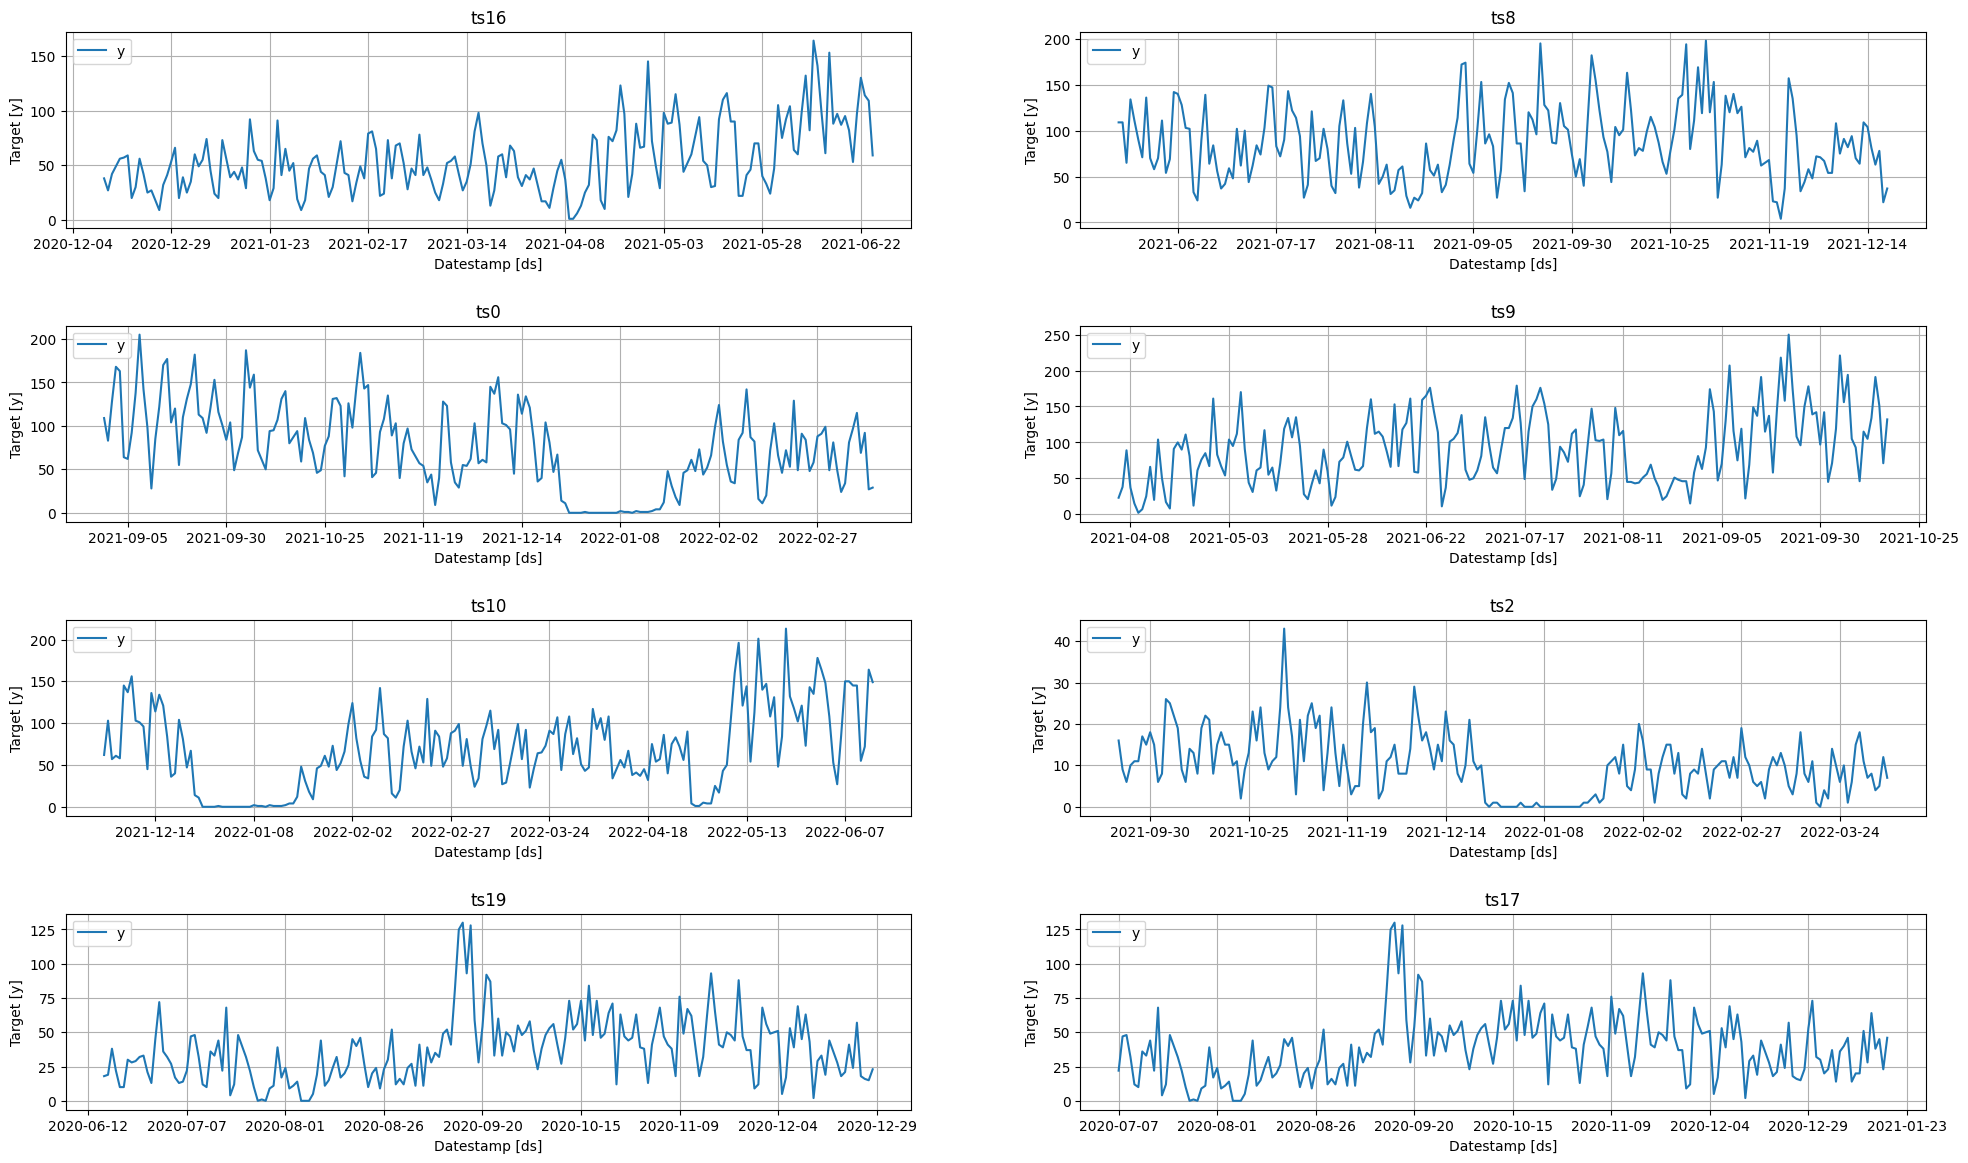

In [7]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df, engine="matplotlib")

In [8]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, loss=RMSE(), num_samples=20),
        AutoNBEATS(h=28, loss=RMSE(), num_samples=20),
        AutoLSTM(h=28, loss=RMSE(), num_samples=20),
    ],
    freq="W",
)

In [9]:
import ray

nf.fit(df=Y_df)

(train_tune pid=8097) Global seed set to 6


Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8097) /AppleInternal/Library/BuildRoots/9941690d-bcf7-11ed-a645-863efbbaf80d/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShaders/MPSCore/Types/MPSNDArray.mm:794: failed assertion `[MPSNDArray, initWithBuffer:descriptor:] Error: buffer is not large enough. Must be 2240 bytes
(train_tune pid=8097) '
(train_tune pid=8097) *** SIGABRT received at time=1682505790 ***
(train_tune pid=8097) PC: @        0x19a104724  (unknown)  __pthread_kill
(train_tune pid=8097)     @        0x10434e2c8  (unknown)  absl::lts_20220623::WriteFailureInfo()
(train_tune pid=8097)     @        0x10434e014  (unknown)  absl::lts_20220623::AbslFailureSignalHandler()
(train_tune pid=8097)     @        0x19a16aa84  (unknown)  _sigtramp
(train_tune pid=8097)     @        0x19a13bc28  (unknown)  pthread_kill
(train_tune pid=8097)     @        0x19a049ae8  (unknown)  abort
(train_tune pid=8097)     @        0x19a048e44  (unknown)  __assert_rtn
(train_tune pid=8097)     @        0x1a36b18ec  (unkno

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(raylet) [2023-04-26 12:43:15,969 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7101214720; capacity: 245107195904. Object creation will fail if spilling is required.
(train_tune pid=8108) Global seed set to 13 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104)     @        0x1641413dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 5x across cluster]
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global seed set to 13
(train_tune pid=8104) Global 

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8108) /opt/homebrew/Caskroom/miniconda/base/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 4 leaked semaphore objects to clean up at shutdown
(train_tune pid=8108)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=8108) Global seed set to 4
(train_tune pid=8114) Extension modules: grpc._cython.cygrpc, msgpack._cmsgpack, setproctitle, psutil._psutil_osx, psutil._psutil_posix, yaml._yaml, ray._raylet, pvectorc, _cffi_backend, zstandard.backend_c, numpy.core._multiarray_umath, numpy.core._multiarray_tests, numpy.linalg._umath_linalg, numpy.fft._pocketfft_internal, numpy.random._common, numpy.random.bit_generator, numpy.random._bounded_integers, numpy.random._mt19937, numpy.random.mtrand, numpy.random._philox, numpy.random._pcg64, numpy.random._sfc64, numpy.random._generator, pyarrow.lib, pyarrow._hdfsio, pyarrow._fs, pyarrow._hdfs, pyarrow._gcsfs, pyarrow._s3fs, pandas._libs.tslibs.np_datet

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8118) Global seed set to 16 [repeated 2x across cluster]
(train_tune pid=8114)     @        0x1559013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8114)     @        0x155c1a6a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8114)     @        0x151c5b6d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8114)     @        0x151c5b04c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8114)     @        0x152893f14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8114) [2023-04-26 12:43:19,277 E 8114 125596] logging.cc:361:     @        0x1559013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8114) [2023-04-26 12:43:19,276 E 8114 125596] logging.cc:361:     @        0x155c1a6a4  (unknown)  at::native::mps::mps_copy_() 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8118) /opt/homebrew/Caskroom/miniconda/base/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 4 leaked semaphore objects to clean up at shutdown
(train_tune pid=8118)   warnings.warn('resource_tracker: There appear to be %d '
2023-04-26 12:43:25,396	WARNING worker.py:1986 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffcd2989656b6834bc88b9046801000000 Worker ID: 097a5a6df023d6e9b44f3185c24560e58e7a148fde196ca75b10ae54 Node ID: fbbbd3cc9c975417b214bce1754566dad94d7c92113aa0a3e2250518 Worker IP address: 127.0.0.1 Worker port: 53775 Worker PID: 8121 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray 

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8126) /opt/homebrew/Caskroom/miniconda/base/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 4 leaked semaphore objects to clean up at shutdown
(train_tune pid=8126)   warnings.warn('resource_tracker: There appear to be %d '
2023-04-26 12:43:31,349	WARNING worker.py:1986 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff894e761587c3c621ba4632b901000000 Worker ID: 975c39ba466a2646a998303c0014d98781f097037770bcf68fce946c Node ID: fbbbd3cc9c975417b214bce1754566dad94d7c92113aa0a3e2250518 Worker IP address: 127.0.0.1 Worker port: 53801 Worker PID: 8131 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8151) Global seed set to 2 [repeated 2x across cluster]
(train_tune pid=8131)     @        0x1207793dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8131)     @        0x120a926a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8131)     @        0x11cad36d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8131)     @        0x11cad304c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8131)     @        0x11d70bf14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8131) [2023-04-26 12:43:31,251 E 8131 126122] logging.cc:361:     @        0x1207793dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8131) [2023-04-26 12:43:31,249 E 8131 126122] logging.cc:361:     @        0x120a926a4  (unknown)  at::native::mps::mps_copy_() [

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8151) /opt/homebrew/Caskroom/miniconda/base/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 4 leaked semaphore objects to clean up at shutdown
(train_tune pid=8151)   warnings.warn('resource_tracker: There appear to be %d '
(raylet) [2023-04-26 12:43:36,069 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7090782208; capacity: 245107195904. Object creation will fail if spilling is required.
2023-04-26 12:43:37,409	WARNING worker.py:1986 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff4d3352869daa14b6719d198c01000000 Worker ID: d659f04ebc487dcddf4fc54017da63f4787a91bae6fc0c97d06ed40a Node ID: fbbbd3cc9c975417b214bce1754566dad94d7c92113aa0a3e2250518 Worker IP address: 127.0.0.1 Worker port: 53826 Worke

Sanity Checking: 0it [00:00, ?it/s]


(train_tune pid=8159) Global seed set to 3 [repeated 2x across cluster]
(train_tune pid=8154)     @        0x1641413dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8154)     @        0x16445a6a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8154)     @        0x16049b6d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8154)     @        0x16049b04c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8154)     @        0x1610d3f14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8154) [2023-04-26 12:43:37,301 E 8154 126372] logging.cc:361:     @        0x1641413dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8154) [2023-04-26 12:43:37,299 E 8154 126372] logging.cc:361:     @        0x16445a6a4  (unknown)  at::native::mps::mps_copy_() [

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8159) /AppleInternal/Library/BuildRoots/9941690d-bcf7-11ed-a645-863efbbaf80d/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShaders/MPSCore/Types/MPSNDArray.mm:794: failed assertion `[MPSNDArray, initWithBuffer:descriptor:] Error: buffer is not large enough. Must be 2240 bytes
(train_tune pid=8159) '
(train_tune pid=8159) *** SIGABRT received at time=1682505820 ***
(train_tune pid=8159) PC: @        0x19a104724  (unknown)  __pthread_kill
(train_tune pid=8159)     @        0x19a16aa84  (unknown)  _sigtramp
(train_tune pid=8159)     @        0x19a13bc28  (unknown)  pthread_kill
(train_tune pid=8159)     @        0x19a049ae8  (unknown)  abort
(train_tune pid=8159)     @        0x19a048e44  (unknown)  __assert_rtn
(train_tune pid=8159)     @        0x1a368e4ac  (unknown)  MTLReportFailure
(train_tune pid=8159)     @        0x1a443d804  (unknown)  MPSNewBufferForTexture
(train_tune pid=8159)     @        0x2022c712c  (unknown)  MetalPerformanceShadersGraph
(train_tune 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8166) Global seed set to 4 [repeated 2x across cluster]
(train_tune pid=8163)     @        0x1559013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8163)     @        0x155c1a6a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8163)     @        0x151c5b6d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8163)     @        0x151c5b04c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8163)     @        0x152893f14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8163) [2023-04-26 12:43:43,322 E 8163 126611] logging.cc:361:     @        0x1559013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8163) [2023-04-26 12:43:43,321 E 8163 126611] logging.cc:361:     @        0x155c1a6a4  (unknown)  at::native::mps::mps_copy_() [

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s] [repeated 2x across cluster]


(train_tune pid=8174) Global seed set to 1 [repeated 2x across cluster]
(train_tune pid=8171)     @        0x14d9013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8171)     @        0x14dc1a6a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8171)     @        0x149c5b6d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8171)     @        0x149c5b04c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8171)     @        0x14a893f14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8171) [2023-04-26 12:43:49,236 E 8171 126852] logging.cc:361:     @        0x14d9013dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8171) [2023-04-26 12:43:49,235 E 8171 126852] logging.cc:361:     @        0x14dc1a6a4  (unknown)  at::native::mps::mps_copy_() [

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(raylet) [2023-04-26 12:43:56,259 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7081017344; capacity: 245107195904. Object creation will fail if spilling is required.
(train_tune pid=8182) Global seed set to 13 [repeated 2x across cluster]
(train_tune pid=8177)     @        0x15c9413dc  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call() [repeated 10x across cluster]
(train_tune pid=8177)     @        0x15cc5a6a4  (unknown)  at::native::mps::mps_copy_() [repeated 4x across cluster]
(train_tune pid=8177)     @        0x158c9b6d8  (unknown)  at::native::copy_impl() [repeated 4x across cluster]
(train_tune pid=8177)     @        0x158c9b04c  (unknown)  at::native::copy_() [repeated 4x across cluster]
(train_tune pid=8177)     @        0x1598d3f14  (unknown)  at::_ops::copy_::call() [repeated 4x across cluster]
(train_tune pid=8177) [2023-04-26 12:43:55,254 E 8177 127077] logging.cc:361:     

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-04-26 12:44:01,376	WARNING worker.py:1986 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffdbd0c265202c5c022b6797a701000000 Worker ID: fabc121d4ad628042c9c7df1a955819324c33a7af9f37efb4ca3baac Node ID: fbbbd3cc9c975417b214bce1754566dad94d7c92113aa0a3e2250518 Worker IP address: 127.0.0.1 Worker port: 53922 Worker PID: 8187 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
2023-04-26 12:44:01,377	ERROR trial_runner.py:1450 -- Trial train_tune_14ef3_00017: Error happened when processing _ExecutorEventType.TRAINING_RESULT.
ray.tune.error._TuneNoNextExecutorEventEr

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=8190) /opt/homebrew/Caskroom/miniconda/base/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 4 leaked semaphore objects to clean up at shutdown
(train_tune pid=8190)   warnings.warn('resource_tracker: There appear to be %d '
(raylet) [2023-04-26 12:44:06,351 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7076401152; capacity: 245107195904. Object creation will fail if spilling is required.
2023-04-26 12:44:07,380	WARNING worker.py:1986 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff41bfde7786108c5ec44dd35801000000 Worker ID: 9598cec80e7246e55a23c6f3df29dc71cc40e24c91489bd9d890fc1f Node ID: fbbbd3cc9c975417b214bce1754566dad94d7c92113aa0a3e2250518 Worker IP address: 127.0.0.1 Worker port: 53946 Worke

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

(raylet) [2023-04-26 12:44:16,449 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7075823616; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2023-04-26 12:44:26,450 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7076990976; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2023-04-26 12:44:36,550 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7076270080; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2023-04-26 12:44:46,551 E 8085 124651] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-26_12-43-04_028896_8032 is over 95% full, available space: 7077326848; capacity: 245107195904. Object creation will fa